In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plotter_lib

pin_memory=False 

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset

torch.autograd.set_detect_anomaly(True)

In [2]:
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

True
NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Define the data transforms to be applied to the images
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Define a custom dataset class that inherits from the PyTorch Dataset class.
class CustomDataset(Dataset):
    
    # Define the constructor of the CustomDataset class that takes in the root directory of the dataset,
    # the mode (train or test), and an optional data transformation function.
    def __init__(self, root_dir, mode, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        
        # Create a list of image paths and labels for the specified mode (train or test).
        self.image_paths = []
        self.labels = []
        class_names = ['DME', 'DRUSEN']
        class_labels = [1, 0]
        for i, class_name in enumerate(class_names):
            class_path = os.path.join(self.root_dir, self.mode, class_name)
            class_label = class_labels[i]
            
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(class_label)
                    
    # Define the length method that returns the number of samples in the dataset.
    def __len__(self):
        return len(self.image_paths)

    # Define the getitem method that returns a sample from the dataset given an index.
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        # Open the image and convert it to RGB format.
        image_high = Image.open(image_path).convert('RGB')
        
        # Apply the data transformation function if provided.
        if self.transform:
            image_high = self.transform(image_high)
            
        # Resize the image to a lower resolution.
        image_low = transforms.Resize(size=32)(image_high)
        
        # Return the low-resolution image, the high-resolution image, and the label.
        return image_low, image_high, label


In [5]:
# Set the main directory for the dataset.
main_dir = './Data/'

# Load all images from the train and test directories using the CustomDataset class and apply
# the specified data transforms.
image_datasets = {
    'train': CustomDataset(root_dir=main_dir, transform=train_transform, mode='train'),
    'test': CustomDataset(root_dir=main_dir, transform=test_transform, mode='test')
}

# Load train and test images using the DataLoader class with a specified batch size, shuffling,
# and number of workers for loading the data in parallel.
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=os.cpu_count()),    
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=os.cpu_count())
}

# Get an image and label batch from the train data loader.
image_low, image_high, labels = next(iter(dataloaders['train']))

# Print the number of images in the train and test sets.
print(f"Number of images in train set: {len(image_datasets['train'])}")
print(f"Number of images in test set: {len(image_datasets['test'])}")

Number of images in train set: 19112
Number of images in test set: 930


In [6]:
print(image_low.shape)
print(image_high.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


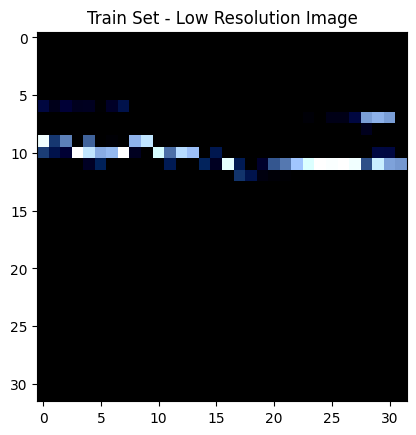

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


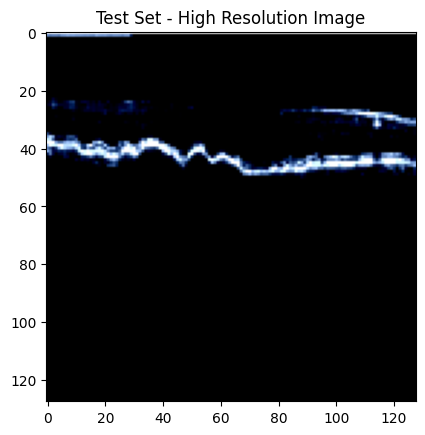

In [7]:
import matplotlib.pyplot as plt

# Display an image from the train set
plt.imshow(image_low[0].permute(1,2,0))
plt.title('Train Set - Low Resolution Image')
plt.show()

# Display an image from the test set
plt.imshow(image_high[0].permute(1,2,0))
plt.title('Test Set - High Resolution Image')
plt.show()


In [8]:
# Define a function to visualize a low-resolution image, a high-resolution image, and a generated image.
def visualize(lr_image, hr_image, generated_image, label, epoch, pretrain, show=False):
    # Move the tensors to the CPU and detach the generated_image tensor.
    lr_image = lr_image.cpu().detach().permute(1, 2, 0).numpy()
    hr_image = hr_image.cpu().detach().permute(1, 2, 0).numpy()
    generated_image = generated_image.cpu().detach().permute(1, 2, 0).numpy()

    # Normalize the pixel values to the range [0, 1] for visualization.
    lr_image = (lr_image - lr_image.min()) / (lr_image.max() - lr_image.min())
    hr_image = (hr_image - hr_image.min()) / (hr_image.max() - hr_image.min())
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    # Plot the images.
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(lr_image)
    axes[0].set_title("Low Resolution")
    axes[1].imshow(hr_image)
    axes[1].set_title("High Resolution")
    axes[2].imshow(generated_image)
    axes[2].set_title("Generated Image")

    # Add some padding to the top of the figure.
    fig.subplots_adjust(top=0.85)

    # Add a common title to the figure depending on the pretrain flag.
    if pretrain:
        fig.suptitle(f" Epoch {epoch} - {label}")
    else:
        fig.suptitle(f"Epoch {epoch} - {label}")
    
    # Create the 'output' directory if it doesn't exist.
    if not os.path.exists('./output'):
        os.makedirs('./output')
    
    # Save and show the figure every 5 epochs or if the show flag is set to True.
    if epoch % 5 == 0 or show:
        fig.savefig(f"./output/epoch_{epoch}_{label}.png")
        plt.show()
    else:
        plt.close(fig)

In [9]:
class residual(nn.Module):
    def __init__(self, num_res_blocks=16):
        super().__init__()
        self.num_res_blocks = num_res_blocks
        
        # First layer
        self.conv1 = nn.Sequential(
            nn.LazyConv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        
        # Add Residual blocks
        res_blocks = []
        for i in range(num_res_blocks):
            res_blocks.append(residual(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(
            nn.LazyConv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d()
        )
        
        # Upsampling Layers
        upsample_layers = []
        for out_channels in [32, 16, 4]:
            upsample_layers += [
                nn.LazyConvTranspose2d(64, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.PReLU()
            ]
        self.upsample_layers = nn.Sequential(*upsample_layers)
        
        # Final output layer
        self.output_layer = nn.Sequential(
            nn.LazyConv2d(4, 3, kernel_size=9, padding=4),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        residual = x
        x = self.res_blocks(x)
        x = self.conv2(x)
        x += residual
        x = self.upsample_layers(x)
        x = self.output_layer(x)
        return x


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        out = self.generator(x)

        return out


In [11]:
generator = Generator().to(device)
test_input = torch.rand(1,3,32,32).to(device)
print(generator(test_input).shape)

/home/david/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 3, 128, 128])


In [12]:
# Define a class for the pre-training generator
class pretraining_generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_train = True
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr):
        # Calculate the content loss between SR and HR images
        content_loss = self.mse_loss(sr, hr)
        return content_loss
    
import torch.nn.functional as F
from torchvision.models import vgg19

# Define a class for the generator loss function
class generator_loss(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a VGG19 model pre-trained on ImageNet
        self.vgg = vgg19(pretrained=True).features[:35].eval()
        # Freeze the parameters of the VGG19 model
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr, discriminator_fake_output):
        # Calculate the content loss between SR and HR images using the VGG19 model
        with torch.no_grad():
            hr_vgg = self.vgg(hr)
        sr_vgg = self.vgg(sr)
        content_loss = self.mse_loss(sr_vgg, hr_vgg)

        # Calculate the adversarial loss using the discriminator output
        adversarial_loss = F.binary_cross_entropy(discriminator_fake_output, torch.ones_like(discriminator_fake_output))

        # Calculate the total generator loss as a weighted sum of the content and adversarial losses
        generator_loss = content_loss + 1e-3 * adversarial_loss

        return generator_loss

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(64, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2)
        )
            
       

        # Add the fully connected part before the final nn.Linear layer
        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # Pass the output through the discriminator blocks (body)
        x = self.body(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass the output through the fully connected part
        x = self.fc(x)

        return x

In [14]:
class discriminator_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, real_pred, fake_pred):
        real_label = torch.ones_like(real_pred)
        fake_label = torch.zeros_like(fake_pred)

        # Loss for real high-resolution images
        real_loss = self.bce_loss(real_pred, real_label)

        # Loss for generated high-resolution images
        fake_loss = self.bce_loss(fake_pred, fake_label)

        # Total discriminator loss
        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [15]:
discriminator = Discriminator().to(device)
test_input = torch.rand(1,3,128,128).to(device)
print(discriminator(test_input).shape)

torch.Size([1, 1])


In [16]:
# Create the 'models' directory if it doesn't exist
if not os.path.exists('./models'):
    os.makedirs('./models')

In [17]:
# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of epochs and the batch size
num_epochs = 100 # 50 epochs of pretraining + 100 of both = 150 total epochs
batch_size = 48
lr = 0.0001
bar_width=150

# Define the loss functions
pretrain_generator_loss = pretraining_generator().to(device)
generator_loss_fn = generator_loss().to(device)
discriminator_loss_fn = discriminator_loss().to(device)

# Move the model parameters to the device
generator.to(device)
discriminator.to(device)

# Define the optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']

pretrain_loss = []
generator_loss_history = []
discriminator_loss_history = []

/home/david/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/david/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting pre-training phase...


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████████████████| 598/598 [01:06<00:00,  9.05it/s, Gen loss=0.0352]


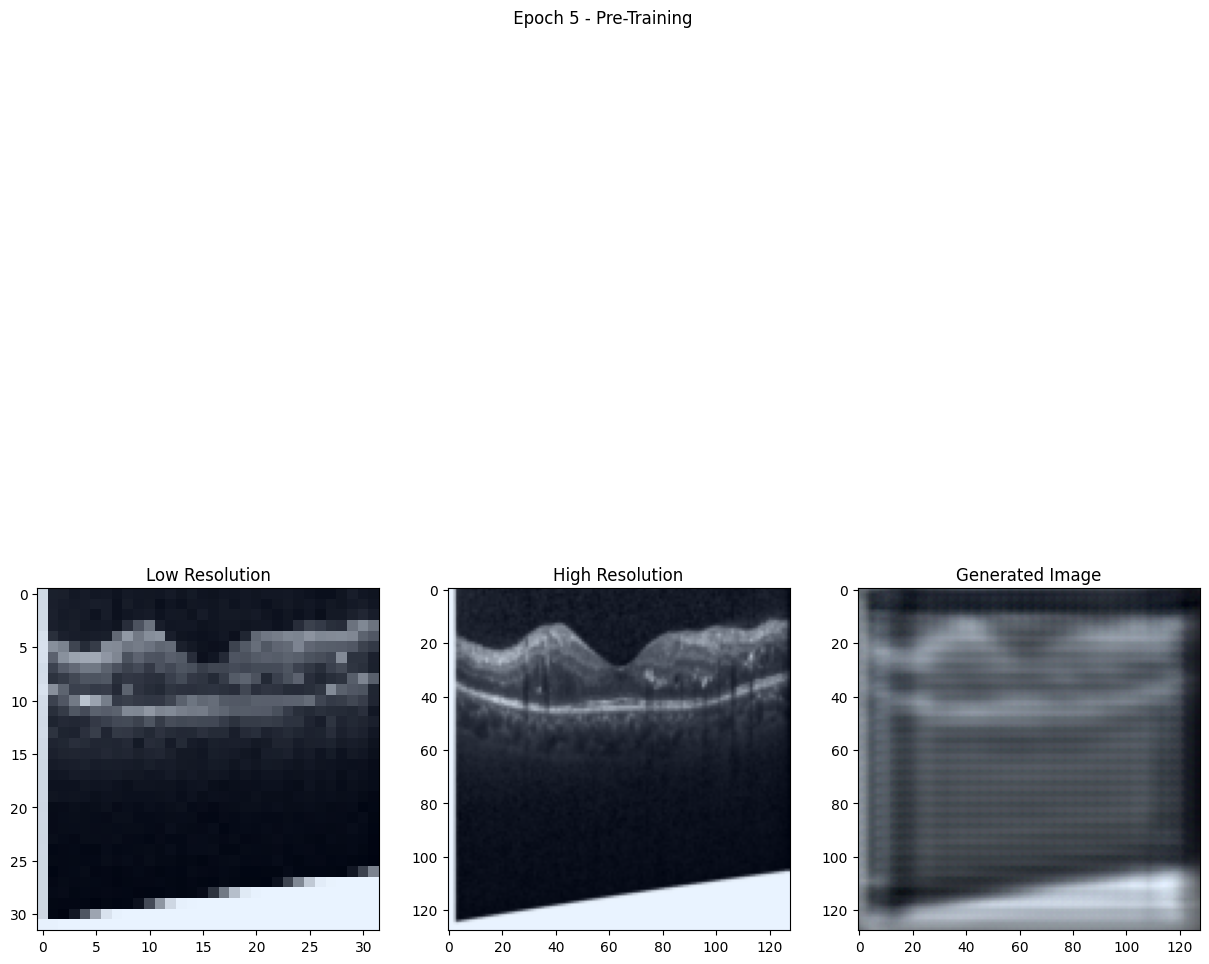

Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.15it/s, Gen loss=0.0269]


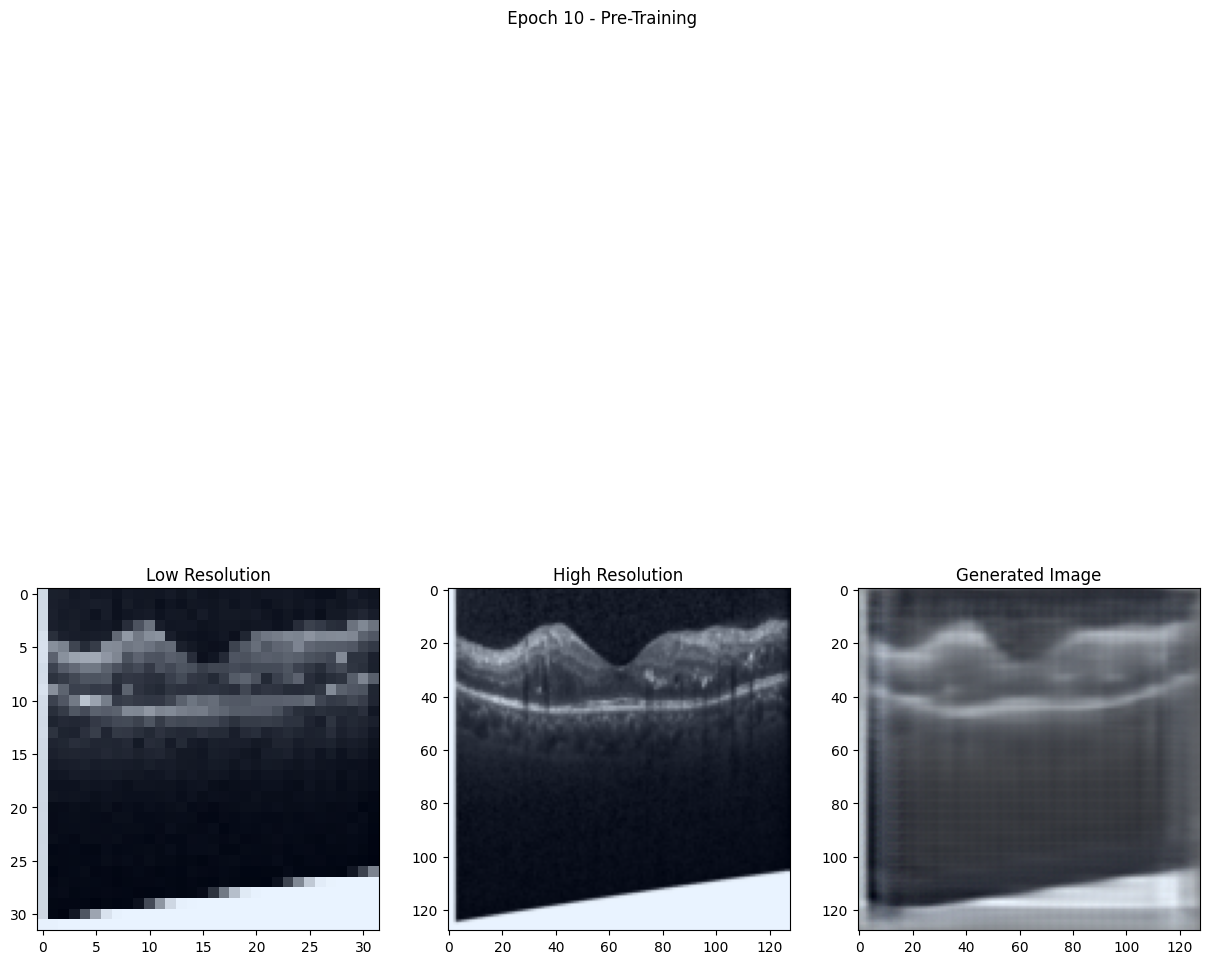

Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.16it/s, Gen loss=0.0279]


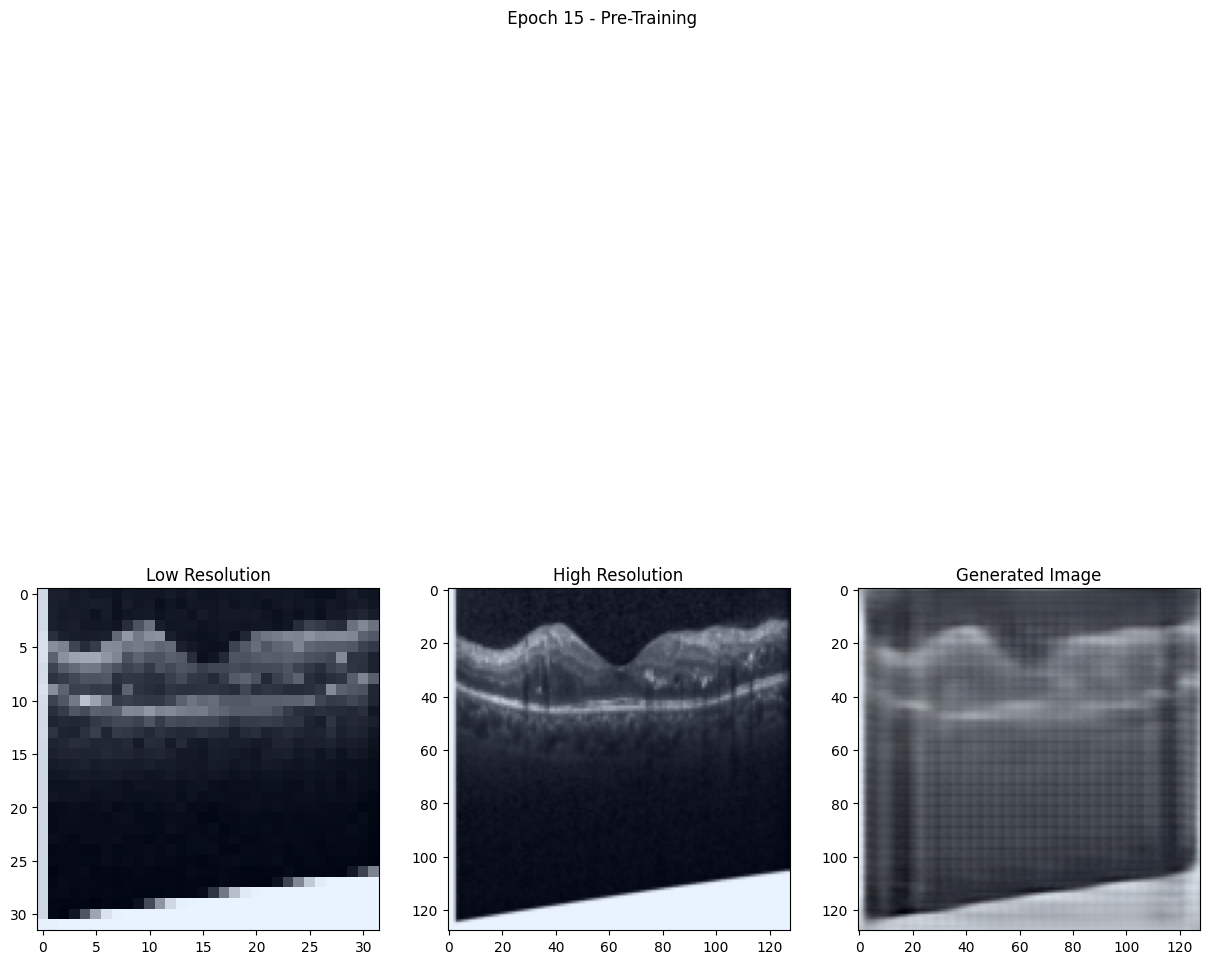

Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.17it/s, Gen loss=0.0259]


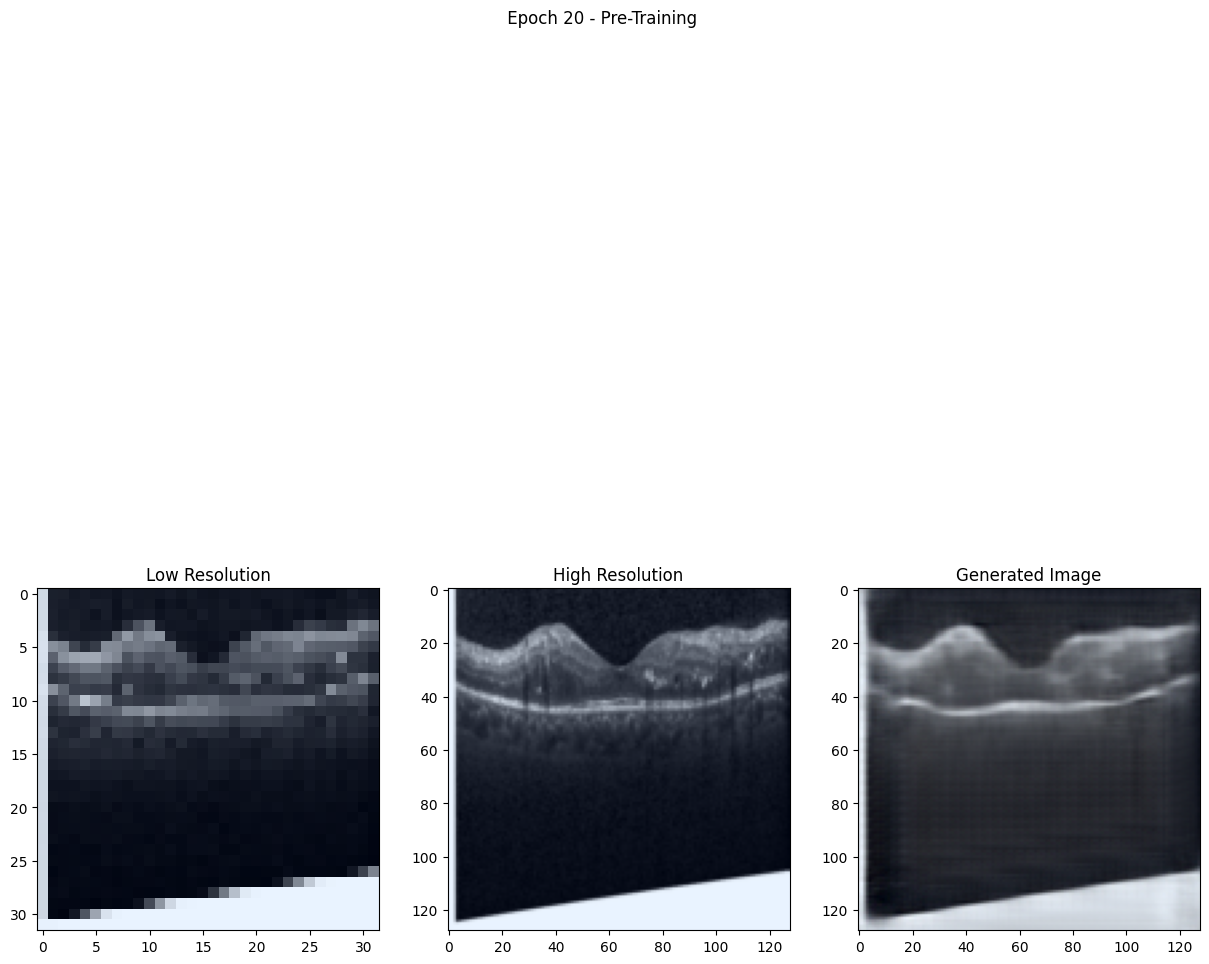

Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.14it/s, Gen loss=0.0206]


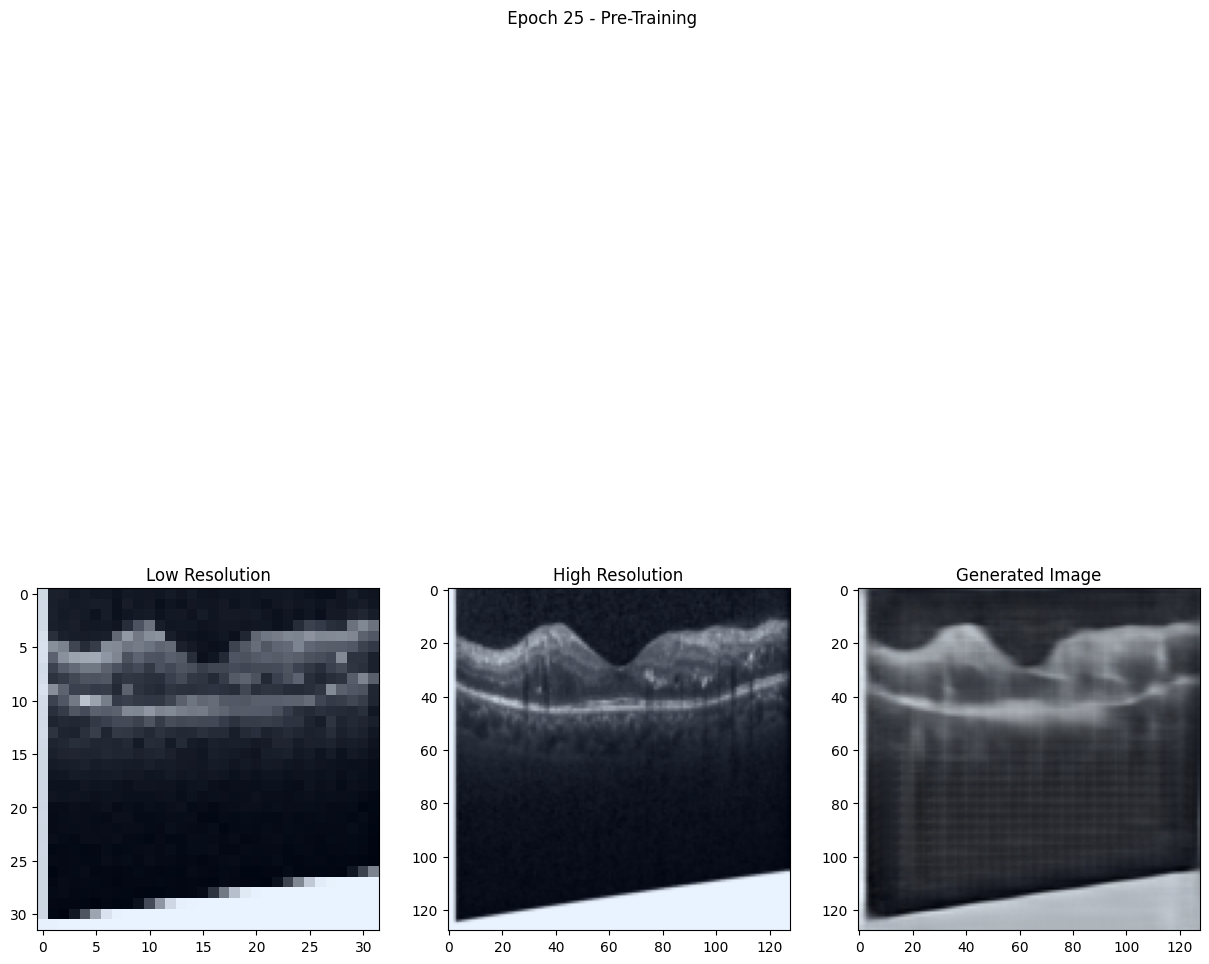

Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.16it/s, Gen loss=0.0240]


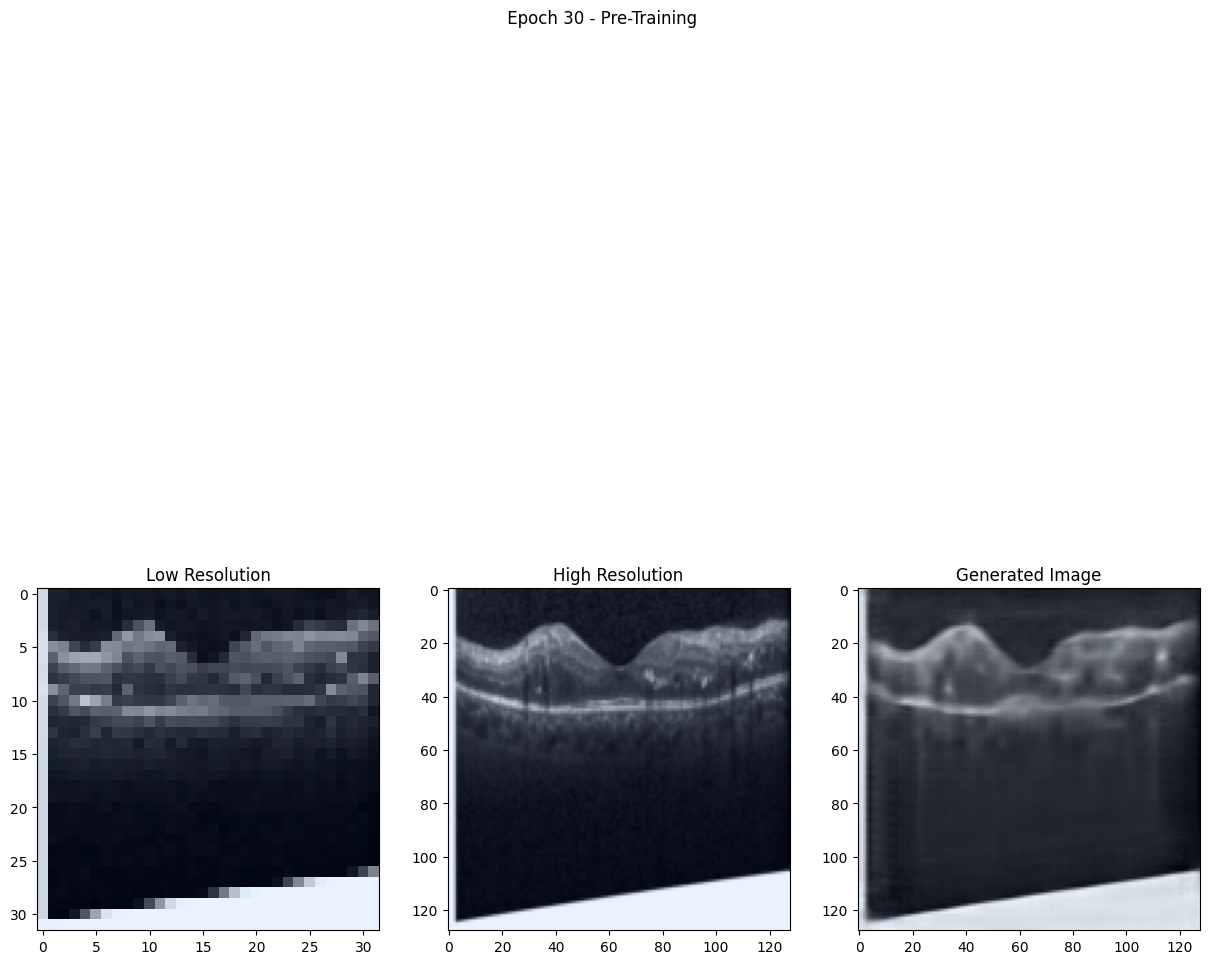

Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.15it/s, Gen loss=0.0190]


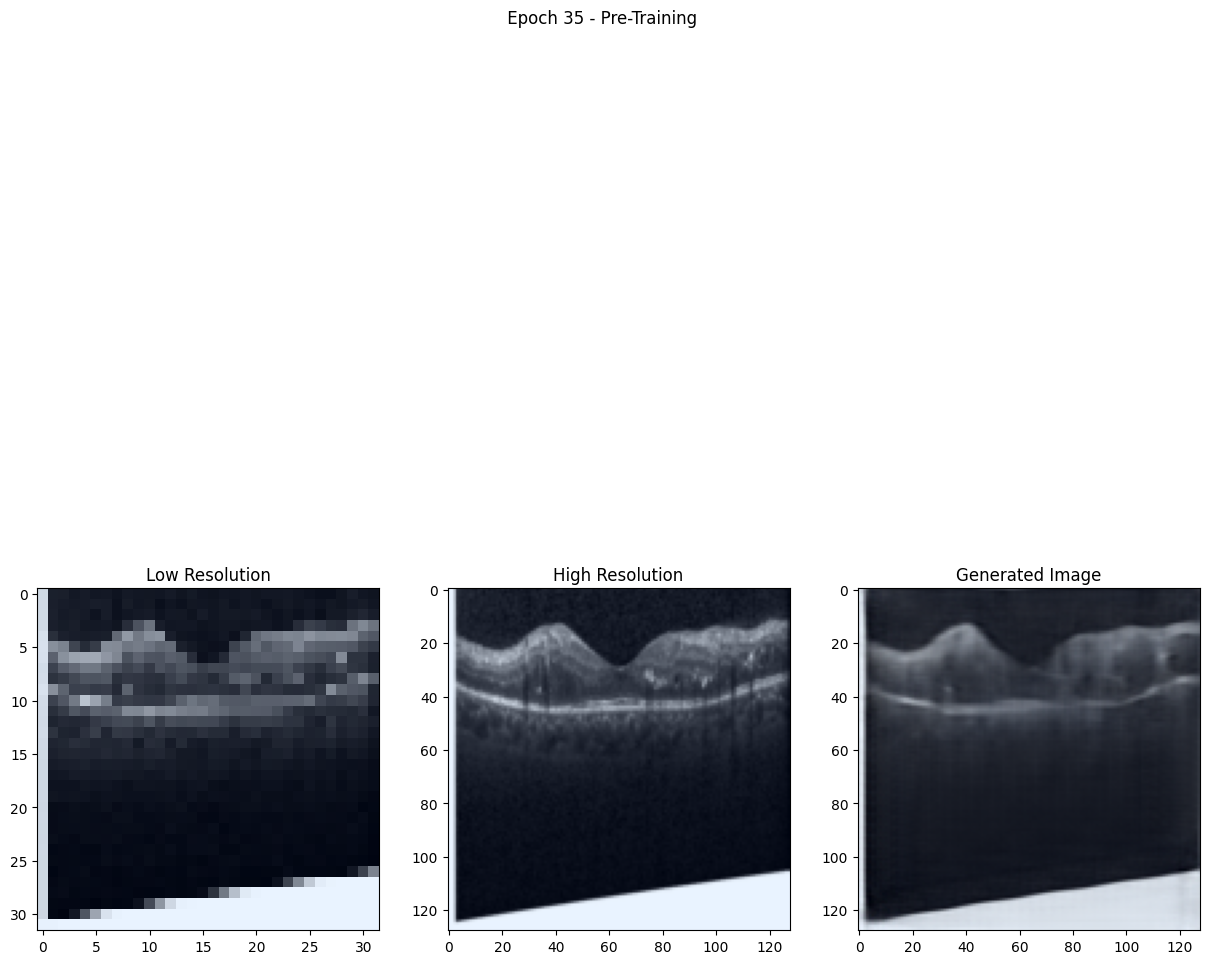

Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.14it/s, Gen loss=0.0212]


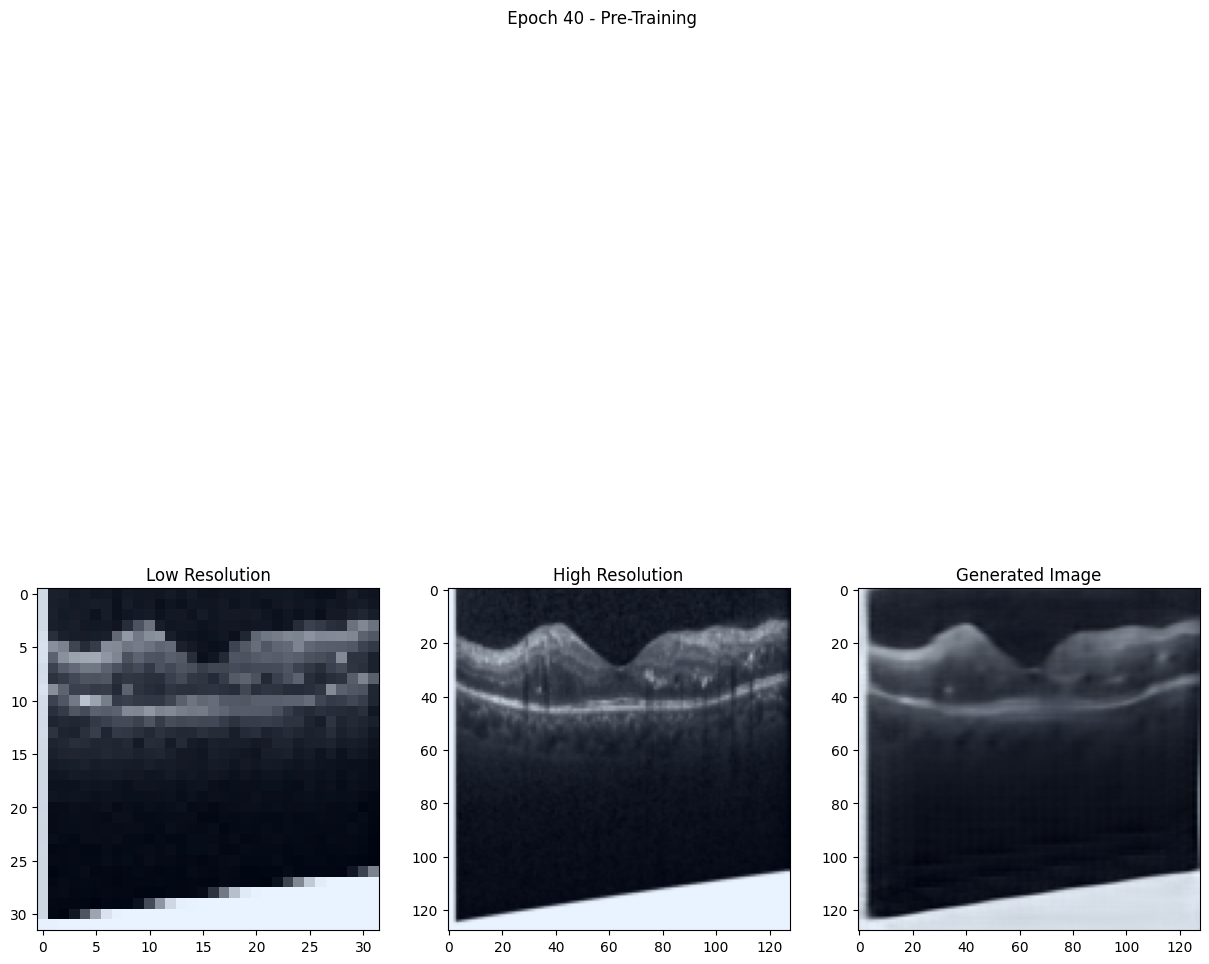

Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.15it/s, Gen loss=0.0169]


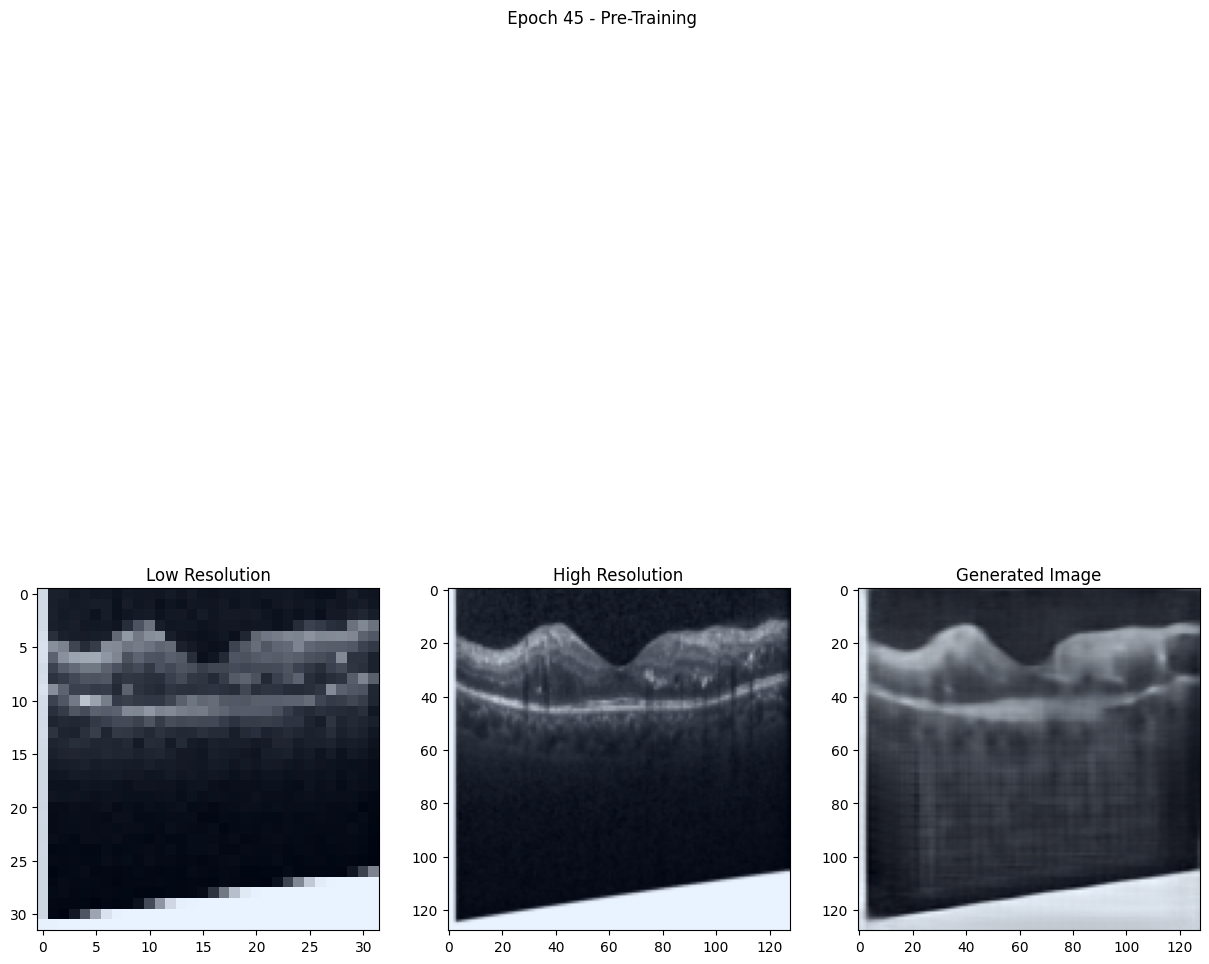

Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.18it/s, Gen loss=0.0200]


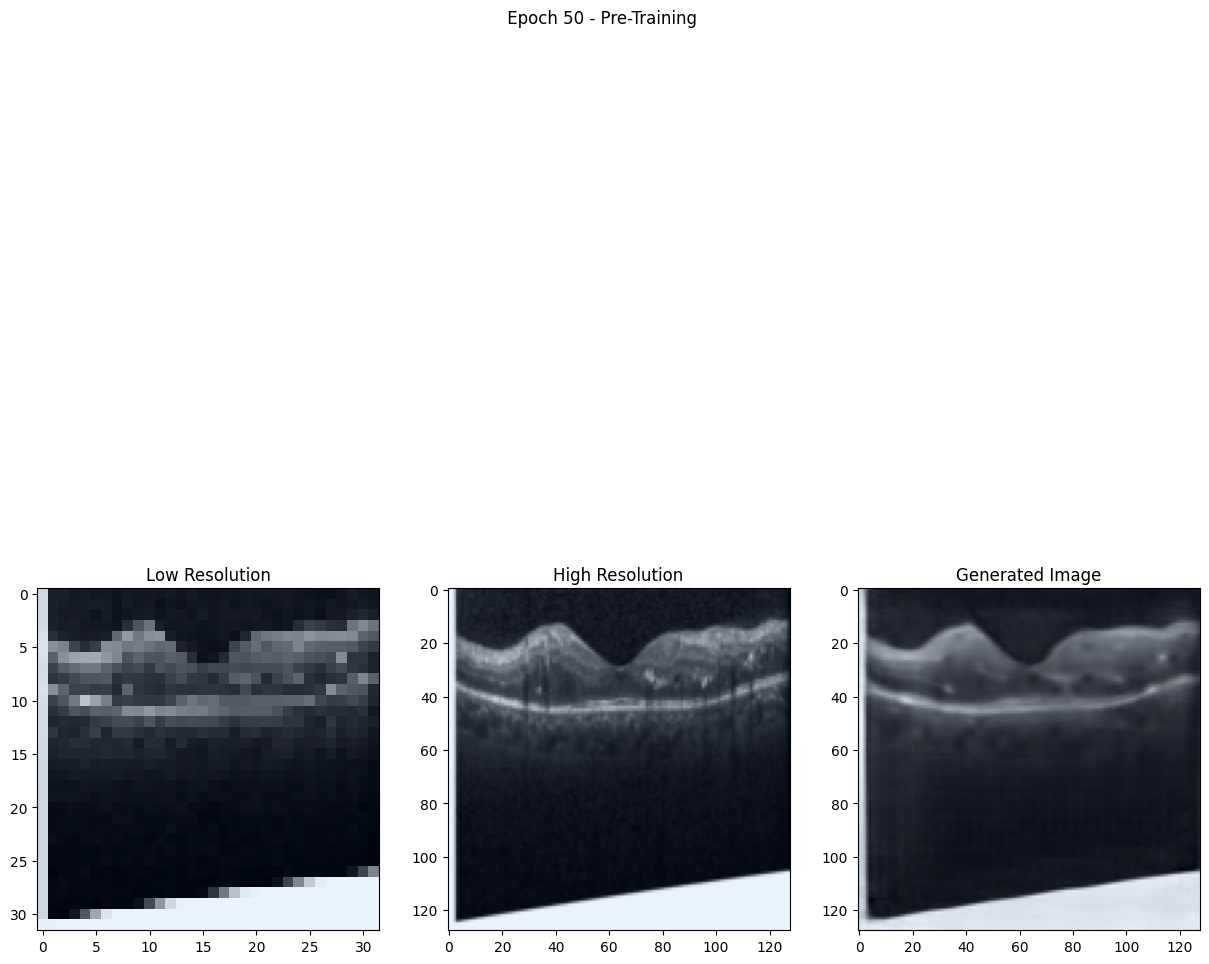

Starting adversarial training phase...


Epoch 1/100:   4%|██▏                                                           | 21/598 [00:44<20:05,  2.09s/it, Gen loss=3.8971, Discr loss=50.0002]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-gyitj6lb'
Epoch 1/100:  12%|███████▎                                                      | 70/598 [02:23<17:29,  1.99s/it, Gen loss=3.8350, Discr loss=50.0001]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-f1f7wb12'
Epoch 1/100:  74%|████████████████████████████████████████████▉                | 441/598 [15:06<05:15,  2.01s/it, Gen loss=1.6250, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-2qfi4quf'
Epoch 1/100:  74%|█████████████████████████████████████████████▍               | 445/598 [15:14<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-vloecijd'
Epoch 2/100:  24%|██████████████▊                                              | 145/598 [04:53<15:17,  2.03s/it, Gen loss=1.3214, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-u6eu3q56'
Epoch 3/100:  18%|██████████▋                                                  | 105/598 [03:32<16:11,  1.97s/it, Gen loss=1.1730, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ayyewl31'
Epoch 3/100:  56%|█████████████████████████████████▊                           | 332/598 [11:10<09:07,  2.06s/it, Gen loss=0.9848, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

Epoch 4/100:  52%|███████████████████████████████▋                             | 311/598 [10:30<09:32,  2.00s/it, Gen loss=1.1188, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ntnsxrkv'
Epoch 4/100:  62%|██████████████████████████████████████                       | 373/598 [12:34<07:45,  2.07s/it, Gen loss=1.1032, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-p36hxvdd'
Epoch 5/100:  30%|██████████████████                                           | 177/598 [05:54<14:12,  2.02s/it, Gen loss=0.9246, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-y4vyy4aq'
Epoch 5/100:  78%|███████████████████████████████████████████████▌             | 466/598 [15:40<04:25,  2.01s/it, Gen loss=1.0816, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

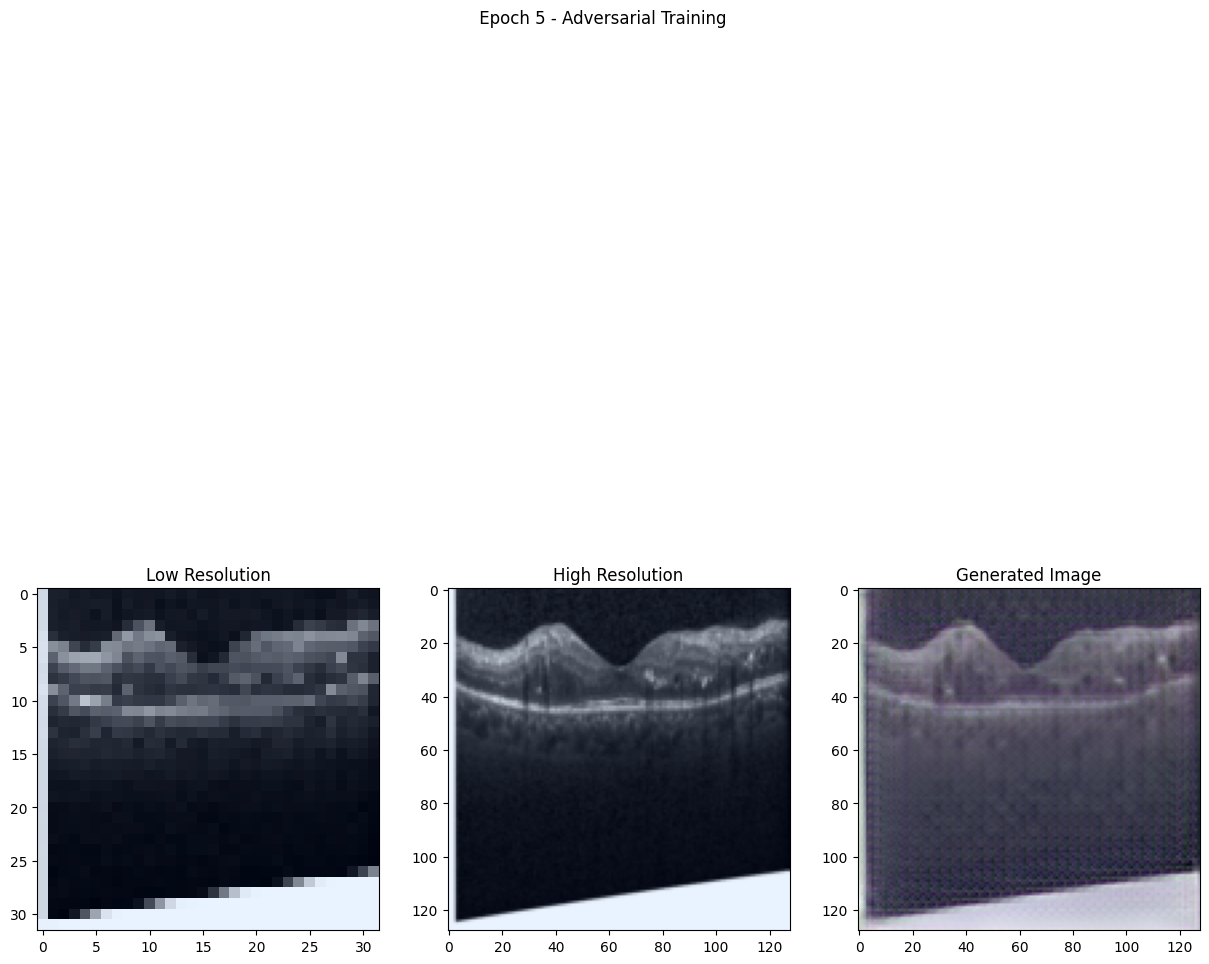

Epoch 6/100:  13%|████████▏                                                     | 79/598 [02:41<17:01,  1.97s/it, Gen loss=1.0769, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-mi64_3pg'
Epoch 6/100:  17%|██████████▏                                                  | 100/598 [03:23<16:24,  1.98s/it, Gen loss=1.0595, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-toi4gdnz'
Epoch 6/100:  51%|███████████████████████████████                              | 304/598 [10:15<10:08,  2.07s/it, Gen loss=1.0661, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-kumbwptc'
Epoch 6/100:  51%|███████████████████████████████▎                             | 307/598 [10:21<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-zjvf84i0'
Epoch 7/100:  19%|███████████▋                                                 | 114/598 [03:52<16:50,  2.09s/it, Gen loss=1.0496, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-hipbn5i8'
Epoch 8/100:  13%|████████                                                      | 78/598 [02:39<17:14,  1.99s/it, Gen loss=0.8719, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-9ek0a2fd'
Epoch 8/100:  75%|█████████████████████████████████████████████▊               | 449/598 [15:07<05:01,  2.03s/it, Gen loss=0.9748, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

OSError: [Errno 39] Directory not empty: '/tmp/pymp-andc05_y'
Epoch 9/100:  45%|███████████████████████████▎                                 | 268/598 [09:04<10:57,  1.99s/it, Gen loss=1.0297, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-cs01lvq1'
Epoch 9/100:  50%|██████████████████████████████▌                              | 299/598 [10:07<10:11,  2.04s/it, Gen loss=0.9783, Discr loss=50.0000]Traceback (most recent ca

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-tmw593_k'
Epoch 10/100:  15%|█████████▎                                                   | 91/598 [03:15<20:22,  2.41s/it, Gen loss=0.8379, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
OSError: [Errno 39] Directory

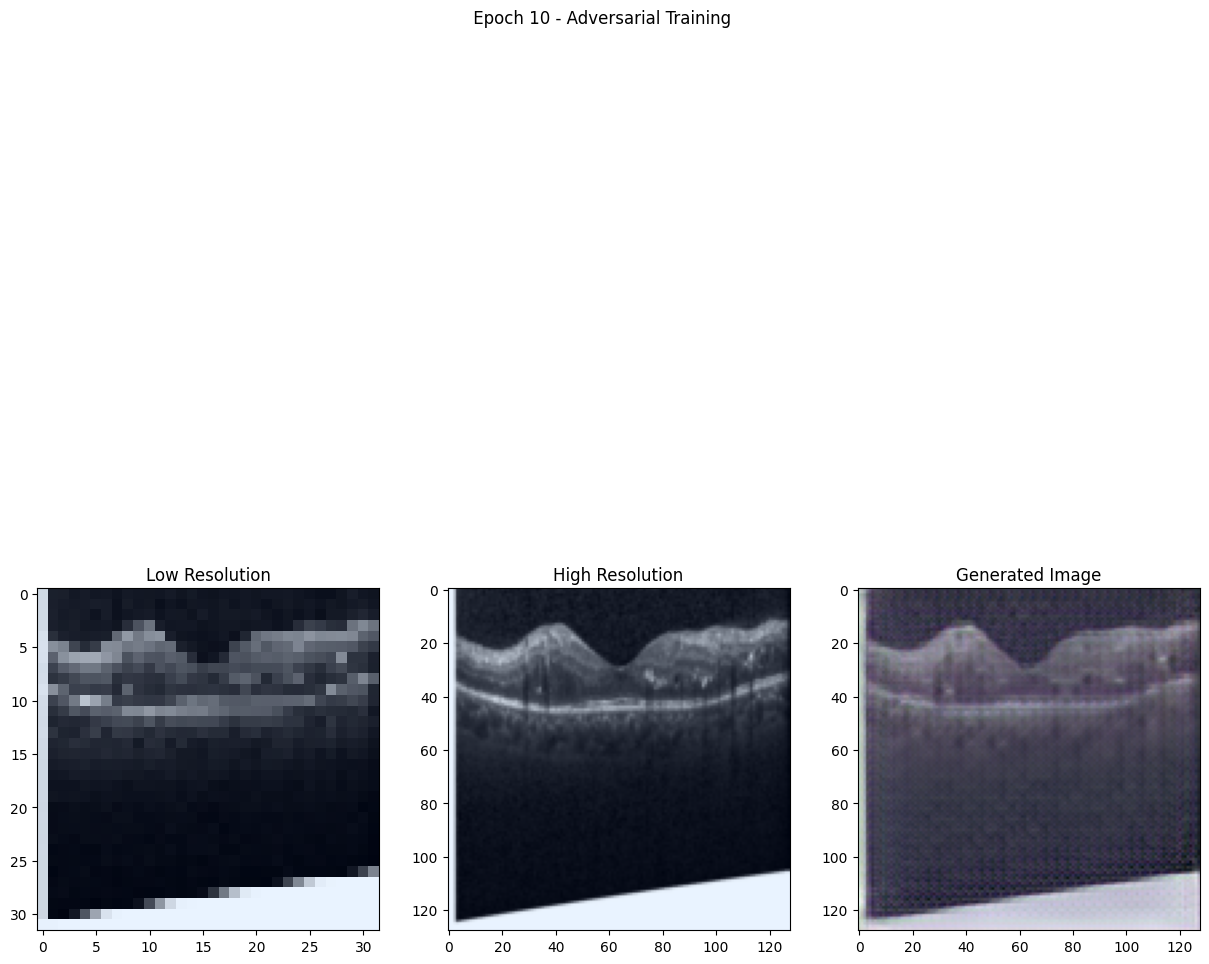

Epoch 11/100:   3%|█▌                                                           | 15/598 [00:31<19:39,  2.02s/it, Gen loss=0.9107, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-2hq5olx9'
Epoch 11/100:   9%|█████▌                                                       | 55/598 [01:50<17:38,  1.95s/it, Gen loss=0.8996, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ii82hhg3'
Epoch 11/100:  41%|████████████████████████▋                                   | 246/598 [08:17<11:37,  1.98s/it, Gen loss=0.9167, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-jtgr_ihc'
Epoch 11/100:  46%|███████████████████████████▍                                | 273/598 [09:13<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-sz09d76z'
Epoch 12/100:  38%|██████████████████████▋                                     | 226/598 [07:36<12:19,  1.99s/it, Gen loss=0.9216, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-pwvumkxx'
Epoch 13/100:  33%|███████████████████▌                                        | 195/598 [06:36<13:07,  1.95s/it, Gen loss=1.0136, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-c_gsb8dg'
Epoch 14/100:  24%|██████████████▌                                             | 145/598 [04:53<15:45,  2.09s/it, Gen loss=0.8083, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-qa_uzn_t'
Epoch 15/100:  28%|████████████████▊                                           | 168/598 [05:42<17:17,  2.41s/it, Gen loss=0.8525, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ej9groh5'
Epoch 15/100:  98%|██████████████████████████████████████████████████████████▉ | 587/598 [19:56<00:21,  1.93s/it, Gen loss=0.8593, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

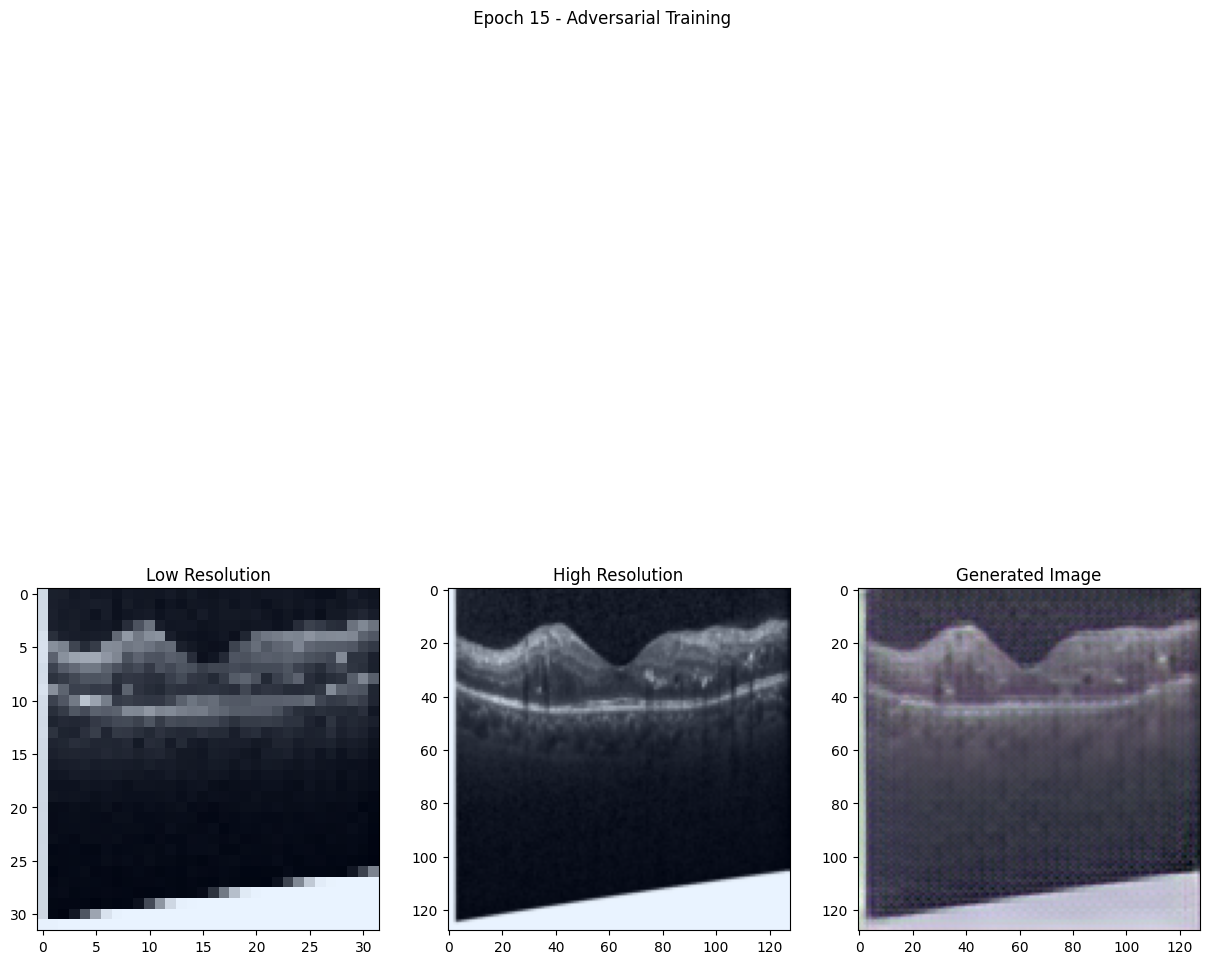

Epoch 16/100:   2%|█                                                            | 11/598 [00:23<20:16,  2.07s/it, Gen loss=0.9251, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-o6bytkxv'
Epoch 16/100:   3%|██                                                           | 20/598 [00:42<19:53,  2.07s/it, Gen loss=0.9017, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-8p7m7sml'
Epoch 16/100:  89%|█████████████████████████████████████████████████████▍      | 532/598 [18:00<02:15,  2.06s/it, Gen loss=0.7757, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-runp1m9u'
Epoch 17/100:   2%|█                                                            | 10/598 [00:21<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-3pzyc35p'
Epoch 17/100:  48%|████████████████████████████▋                               | 286/598 [09:37<10:13,  1.97s/it, Gen loss=0.8927, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-5k12odop'
Epoch 18/100:  45%|██████████████████████████▊                                 | 267/598 [08:58<11:02,  2.00s/it, Gen loss=0.8395, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-xvte7rk1'
Epoch 20/100:   8%|████▌                                                        | 45/598 [01:31<18:35,  2.02s/it, Gen loss=0.8503, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-qgh5a1jp'
Epoch 20/100:   8%|████▉                                                        | 49/598 [01:39<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ifzuedhu'
Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 598/598 [20:10<00:00,  2.02s/it, Gen loss=0.8766, Discr loss=50.0000]


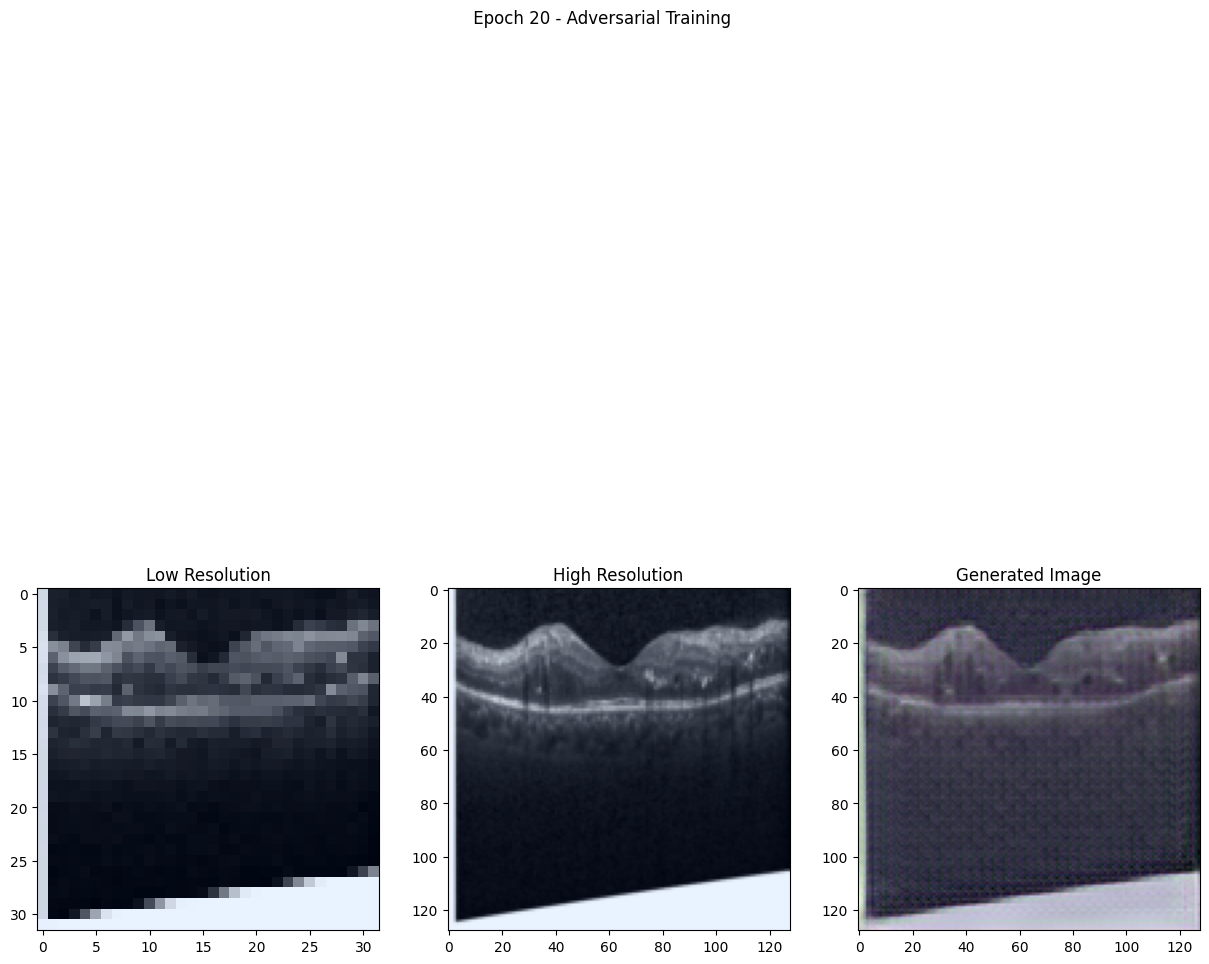

Epoch 21/100:   0%|                                                                                                           | 0/598 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-y9hfxs3l'
Epoch 21/100:   7%|████▏                                                        | 41/598 [01:24<18:45,  2.02s/it, Gen loss=0.7549, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

Epoch 21/100:  33%|████████████████████                                        | 200/598 [06:45<13:10,  1.99s/it, Gen loss=0.8293, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-bpj12nbl'
Epoch 21/100:  92%|███████████████████████████████████████████████████████▎    | 551/598 [18:34<01:36,  2.06s/it, Gen loss=0.7857, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-o459kx3c'
Epoch 22/100:  64%|██████████████████████████████████████▋                     | 385/598 [12:51<07:08,  2.01s/it, Gen loss=0.8049, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-frr1aqaa'
Epoch 23/100:  42%|█████████████████████████▏                                  | 251/598 [08:27<12:03,  2.09s/it, Gen loss=0.8661, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-h5p9_5v_'
Epoch 24/100:  73%|████████████████████████████████████████████                | 439/598 [14:47<05:16,  1.99s/it, Gen loss=0.9196, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-xsiytbl3'
Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 598/598 [20:19<00:00,  2.04s/it, Gen loss=0.7494, Discr loss=50.0000]


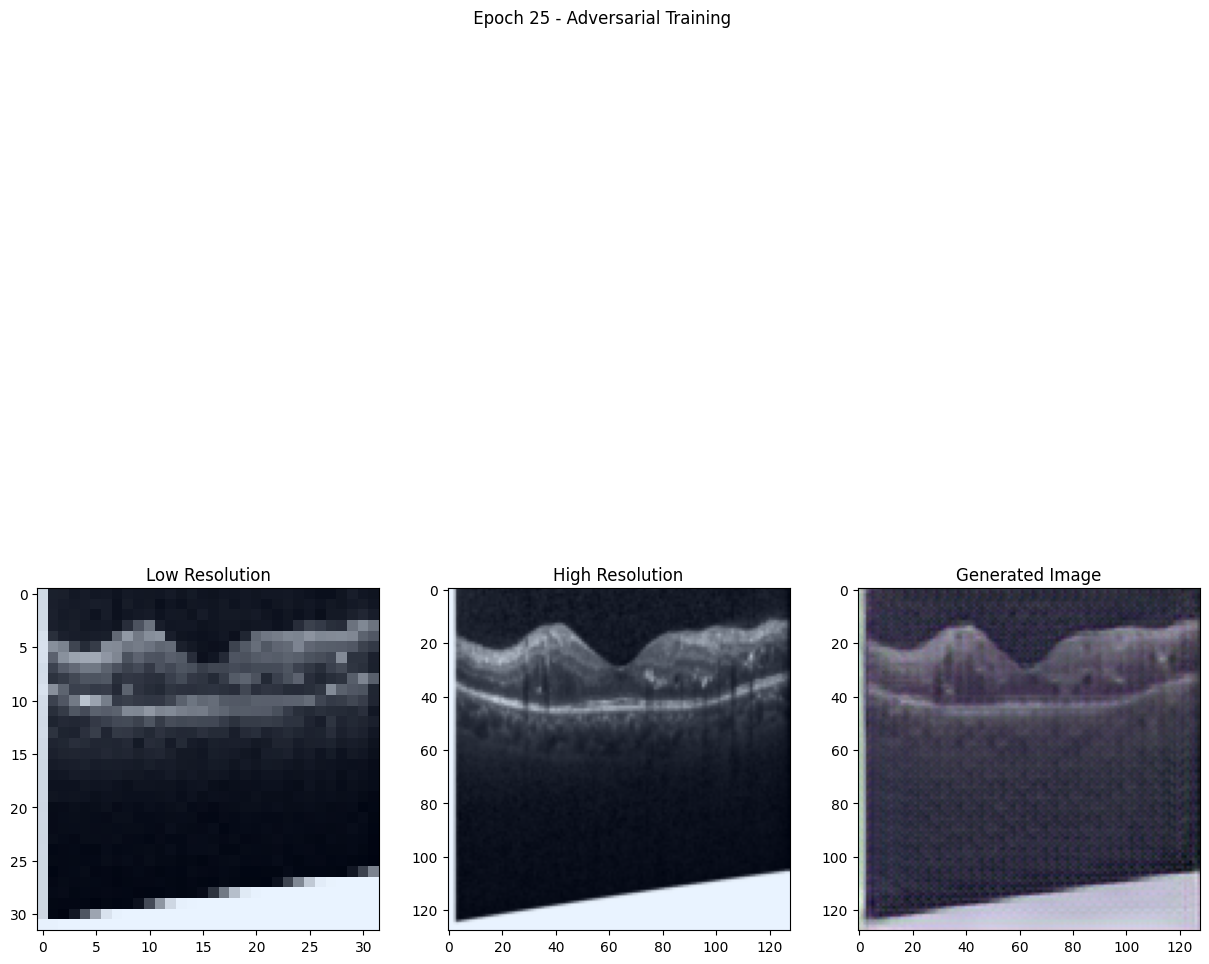

Epoch 26/100:  11%|██████▍                                                      | 63/598 [02:08<17:55,  2.01s/it, Gen loss=0.8036, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-c5yt4by3'
Epoch 26/100:  13%|███████▊                                                     | 76/598 [02:34<17:14,  1.98s/it, Gen loss=0.7949, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-p3y4hlc2'
Epoch 26/100:  58%|██████████████████████████████████▌                         | 345/598 [11:37<08:25,  2.00s/it, Gen loss=0.6992, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-s4960zyt'
Epoch 26/100:  59%|███████████████████████████████████▌                        | 355/598 [11:57<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-z_jg_c7l'
Epoch 27/100:  15%|████████▉                                                    | 88/598 [03:00<17:17,  2.03s/it, Gen loss=0.7737, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
Epoch 29/100:  23%|█████████████▌                                              | 135/598 [04:34<15:49,  2.05s/it, Gen loss=0.7620, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    o

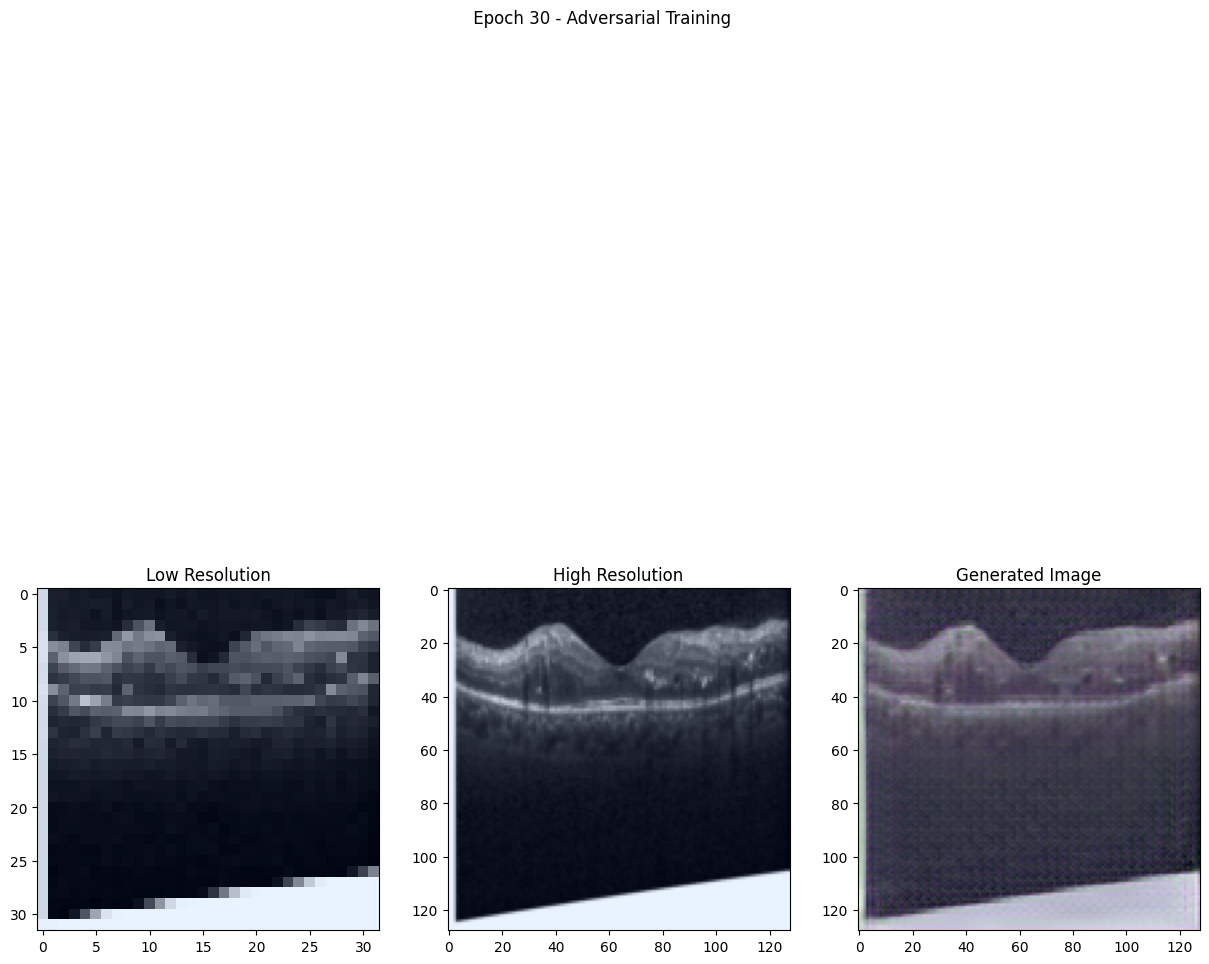

Epoch 31/100:   0%|                                                                                                           | 0/598 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
from tqdm import tqdm
# Pre-training phase
print("Starting pre-training phase...")
for epoch in range(50):
    generator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{50}",ncols=bar_width)
    
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Compute the loss and update the parameters
        generator_loss_value = pretrain_generator_loss(sr_images, hr_images)
        generator_optimizer.zero_grad()
        generator_loss_value.backward(retain_graph=True)
        generator_optimizer.step()

        pretrain_loss.append(generator_loss_value.item())
        
        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}"})
        pbar.update()

    pbar.close()
    
    
    # Save the generator model every 5 epochs
    #if (epoch+1) % 5 == 0:
        #torch.save(generator.state_dict(), f"./models/generator_model_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize(lr_images[0], hr_images[0], sr_images[0], "Pre-Training", epoch+1, True)

# Adversarial training phase
print("Starting adversarial training phase...")
                         
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", ncols=bar_width)
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Train the discriminator
        discriminator_optimizer.zero_grad()

        real_labels = torch.ones(hr_images.size(0), 1).to(device)
        fake_labels = torch.zeros(hr_images.size(0), 1).to(device)

        discriminator_real_output = discriminator(hr_images)
        discriminator_fake_output = discriminator(sr_images)

        discriminator_loss_fn = discriminator_loss().to(device)

        discriminator_real_loss = discriminator_loss_fn(discriminator_real_output, real_labels)
        discriminator_fake_loss = discriminator_loss_fn(discriminator_fake_output, fake_labels)

        discriminator_loss_value = discriminator_real_loss + discriminator_fake_loss
        discriminator_loss_value.backward()
        discriminator_optimizer.step()


        # Train the generator
        generator_optimizer.zero_grad()
        sr_images = generator(lr_images)
        discriminator_fake_output = discriminator(sr_images)

        generator_loss_value = generator_loss_fn(sr_images, hr_images, discriminator_fake_output)
        generator_loss_value.backward()
        generator_optimizer.step()

        discriminator_loss_history.append(discriminator_loss_value.item())
        generator_loss_history.append(generator_loss_value.item()) # moved here


        # Get new data from the train_loader
        lr_images, hr_images, _ = next(iter(train_loader))
        lr_images = lr_images.detach()
        hr_images = hr_images.detach()
        
        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}", "Discr loss": f"{discriminator_loss_value.item():.4f}"})
        pbar.update()



    pbar.close()
    # Save the generator and discriminator models every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_epoch_{epoch+1}.pt")
        torch.save(discriminator.state_dict(), f"./models/discriminator_epoch_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize(lr_images[0], hr_images[0], sr_images[0], "Adversarial Training", epoch+1, True)


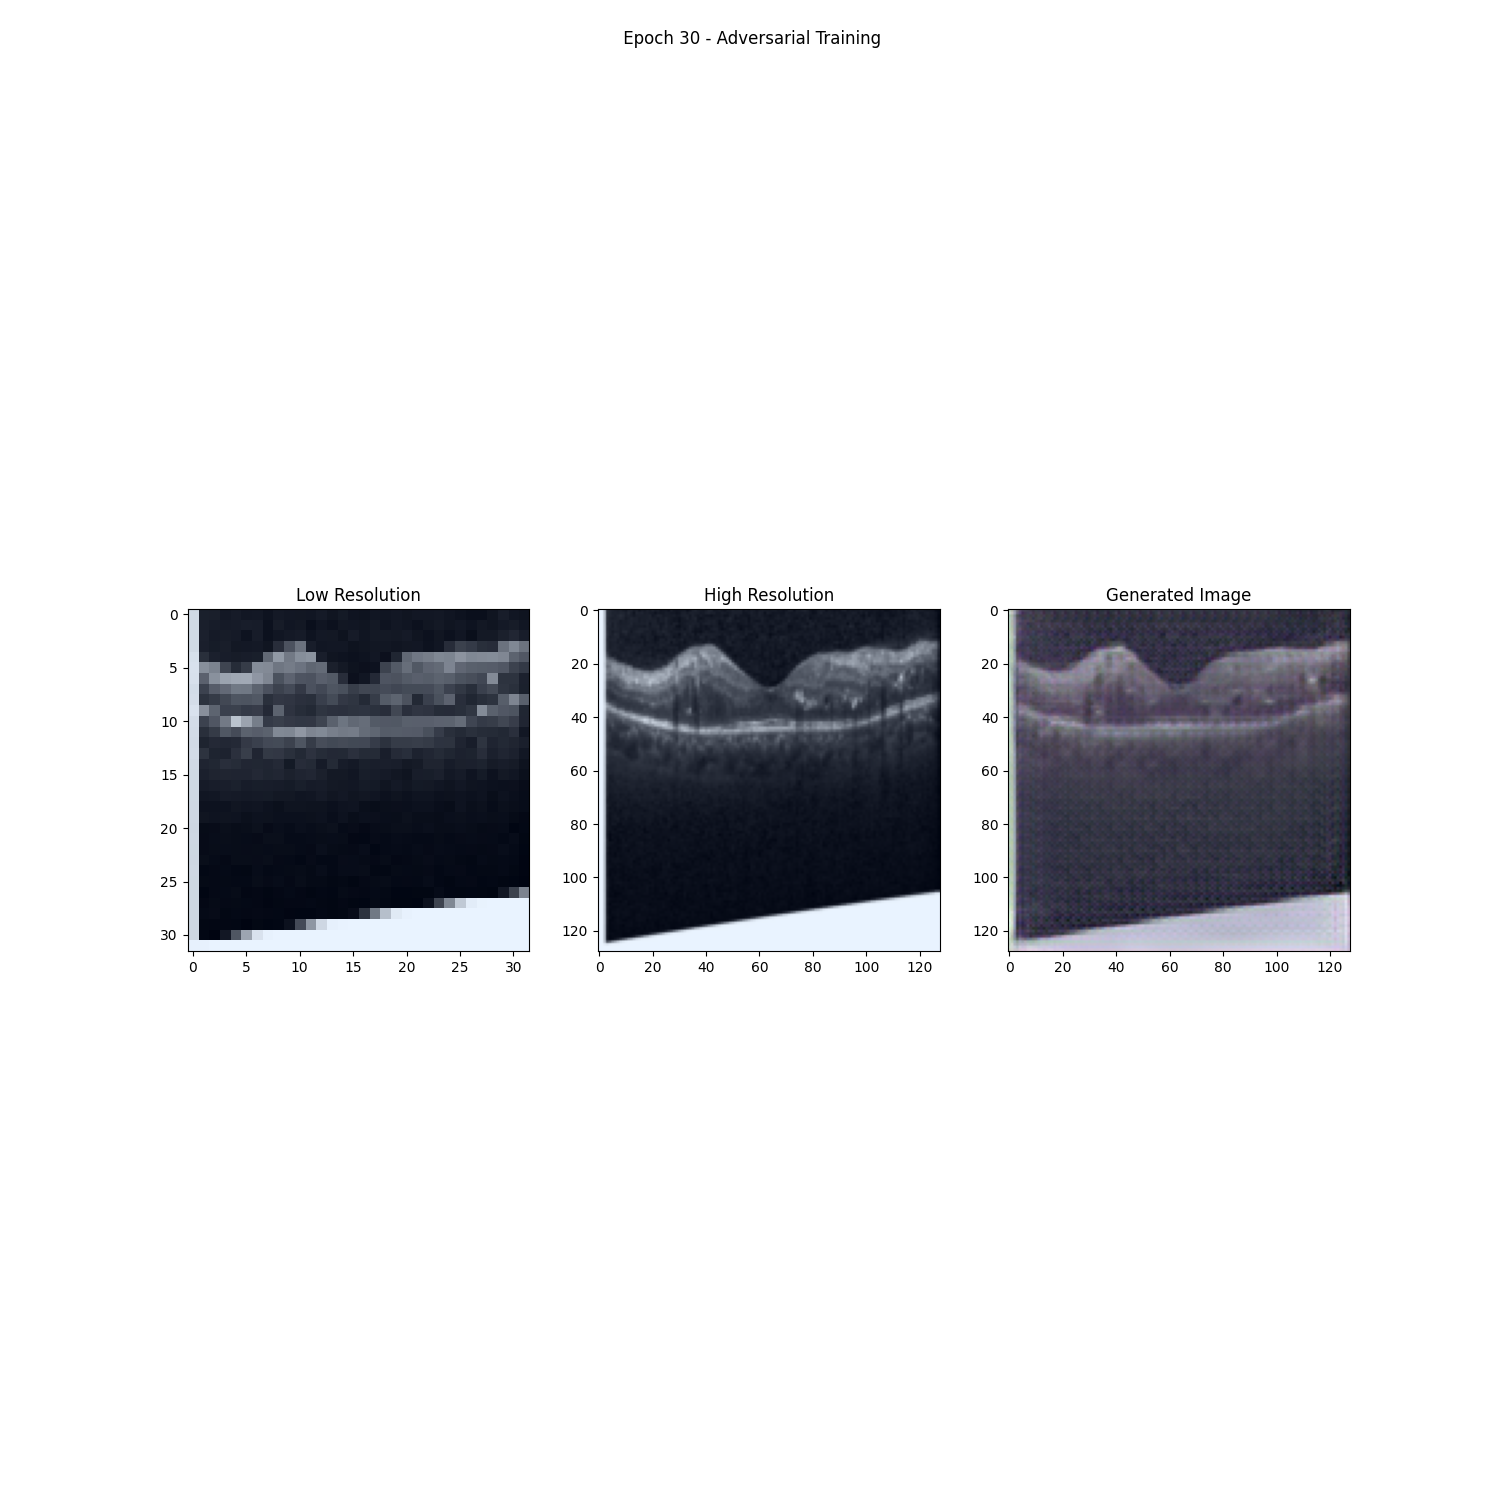

In [19]:
from IPython.display import Image

Image(filename='./output/epoch_30_Adversarial Training.png')
#last epoch

##### 